In [ ]:
#Mount dữ liệu đến gg drive
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/HK2 - Năm 3/Phân tích dữ liệu kinh doanh - IS403.P21/Dữ liệu bài thực hành"

Mounted at /content/drive
/content/drive/My Drive/HK2 - Năm 3/Phân tích dữ liệu kinh doanh - IS403.P21/Dữ liệu bài thực hành


In [ ]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Đọc file CSV
df = pd.read_csv('Intel Stock Price History.csv', sep=',')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,04/01/2025,22.05,22.56,22.62,21.66,64.06M,-2.91%
1,03/31/2025,22.71,22.38,22.75,21.75,65.83M,0.00%
2,03/28/2025,22.71,23.35,23.58,22.56,58.37M,-3.85%
3,03/27/2025,23.62,23.28,23.76,22.85,57.72M,0.85%
4,03/26/2025,23.42,24.25,24.42,23.25,59.68M,-3.22%


In [ ]:
# Chỉ lấy Date và Close
df = df[['Date', 'Price']]

# Chuyển Date thành datetime và sắp xếp
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Chuyển Date thành số ordinal
df['DateOrdinal'] = df['Date'].map(lambda date: date.toordinal())

# Tiền xử lý - chuẩn hóa
X = df[['DateOrdinal']].values  # Biến độc lập (ngày)
y = df['Price'].values.reshape(-1, 1)  # Biến phụ thuộc (giá)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


<ipython-input-12-599547a1ded9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
# Bước 2: Tính toán chênh lệch giá đóng cửa
diff = np.diff(y_scaled.flatten())  # lấy chênh lệch giữa các giá đã chuẩn hóa
diff = diff.reshape(-1, 1)  # hmmlearn yêu cầu (n_samples, n_features)

In [ ]:
# 3. Chia tập train/test: 80% train, 20% test
split_index = int(len(diff) * 0.8)
X_train, X_test = X_scaled[1:split_index+1], X_scaled[split_index+1:]
diff_train, diff_test = diff[:split_index], diff[split_index:]

In [ ]:
lowest_bic = np.inf
bic = []
n_components_range = range(2, 10)

for n_components in n_components_range:
    model = GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000, random_state=42)
    model.fit(diff_train)

    # BIC = -2 * log likelihood + num_params * log(N)
    log_likelihood = model.score(diff_train)
    n_parameters = n_components * 2 + n_components * (n_components - 1)
    bic_value = -2 * log_likelihood + n_parameters * np.log(len(diff_train))

    bic.append(bic_value)
    if bic_value < lowest_bic:
        lowest_bic = bic_value
        best_model = model

# Sử dụng best_model
model = best_model

Mean Squared Error (MSE) trên Test: 99.3880
Mean Absolute Error (MAE) trên Test: 8.2324
R2 Score trên Test: -0.4085


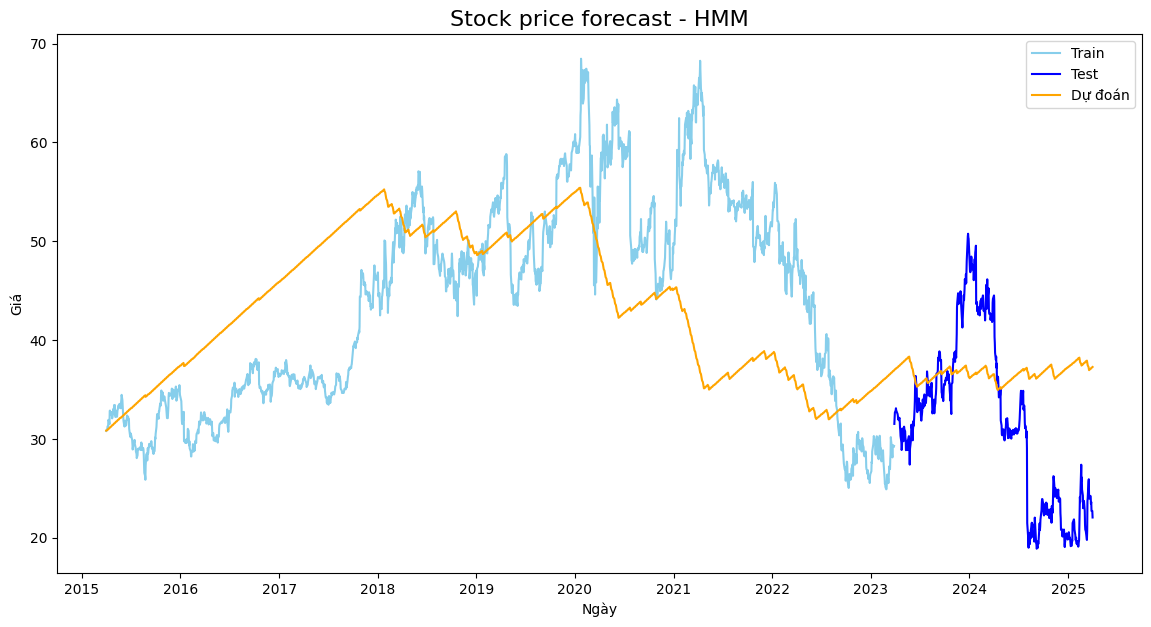

In [ ]:
# 4. Huấn luyện mô hình HMM
model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000,random_state=42)
#model = GaussianHMM(n_components=3, covariance_type="full", n_iter=2000,tol=1e-4, random_state=42)

model.fit(diff_train)

# 5. Dự đoán cho toàn bộ diff
hidden_states = model.predict(diff)
means = model.means_.flatten()
predicted_diff = means[hidden_states]

# Tái tạo chuỗi giá dự đoán
predicted_scaled = [y_scaled[0][0]]
for d in predicted_diff:
    predicted_scaled.append(predicted_scaled[-1] + d)
predicted_scaled = np.array(predicted_scaled[1:]).reshape(-1, 1)

predicted_real = scaler_y.inverse_transform(predicted_scaled)

# Giá thực tế
y_real = df['Price'].values[1:]  # tương ứng với diff

# 6. Tính chỉ số đánh giá cho phần Test
y_test_real = y_real[split_index:]
predicted_test_real = predicted_real[split_index:]

mse = mean_squared_error(y_test_real, predicted_test_real)
mae = mean_absolute_error(y_test_real, predicted_test_real)
r2 = r2_score(y_test_real, predicted_test_real)

print(f"Mean Squared Error (MSE) trên Test: {mse:.4f}")
print(f"Mean Absolute Error (MAE) trên Test: {mae:.4f}")
print(f"R2 Score trên Test: {r2:.4f}")

# 7. Vẽ biểu đồ
plt.figure(figsize=(14, 7))

# Train set
plt.plot(df['Date'][1:split_index+1], y_real[:split_index], color='skyblue', label='Train')

# Test set
plt.plot(df['Date'][split_index+1:], y_real[split_index:], color='blue', label='Test')

# Du doan tren toan doan
plt.plot(df['Date'][1:], predicted_real, color='orange', label='Dự đoán')

# Chỉ vẽ dự đoán từ đoạn Test
#plt.plot(df['Date'][split_index+1:], predicted_test_real, color='orange', label='Dự đoán')

plt.title('Stock price forecast - HMM', fontsize=16)
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.legend()
plt.show()